# Smart home - topic modelling (LDA)
#### Source Data
2904 reddit comments form the subreddits **smarthome** and **homeautomation** extracted with [pushshift API](https://github.com/pushshift/api) using privacy, trust and security as query terms and size equal 500 (maximum allowed for each request).


In [188]:
import json
import re
import warnings
from collections import Counter, defaultdict

import gensim
import gensim.corpora as corpora
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
import spacy
import scipy.stats
from collections import OrderedDict
from bokeh.io import output_notebook
from bokeh.models import Label
from bokeh.plotting import figure, output_file, show
from gensim.models import CoherenceModel, LsiModel, HdpModel, LdaModel
from gensim.utils import simple_preprocess
from gensim.test.utils import datapath
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.manifold import TSNE
from wordcloud import STOPWORDS, WordCloud

## Run in terminal with the size wanted 
# python3 pushshift_comments.py 10

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# import training data

df = pd.read_csv('comments_query.csv', encoding='utf8')

# Cleaning up the comments
# nltk.download('stopwords')  # (run python console)
# nltk.download('wordnet')  # (run python console)
# python3 -m spacy download en  # (run in terminal)


## Pre-processing
- Strip out hyperlinks and copy thme in a new column URL
- Find all words with a hyphen between them and consider them as a unique word ('technical vocabulary')
- Remove common stop words
- Remove previous comments (copied text) within the comment
- Remove punctuation
- Remove digits
- Remvoe word that are less then 2 characters
- Keep only noun, adjectives, verbs and proper nouns
- Apply lemmantization

In [ ]:
# Extracting URLs: external links often informative, but they add unwanted noise to our NLP model
# Strip out hyperlinks and copy thme in a new column URL

# Find URL
def Find(string): 
    # with valid conditions for urls in string 
    url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', string) 
    return url

# apply the function on the body column
df['URL'] = df.body.apply(find_URL)

# create a colummn with pre-processed:
df['clean_body'] = [re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', x) for x in df['body']]

In [189]:
# Find all internal hyphen words and consider them as full words ('technical vocabulary')
df['clean_body'] = [re.sub(r'([a-zA-Z]+)(-)([a-zA-Z]+)', r'\g<1>\g<3>', x) for x in df['clean_body']]

In [190]:
# Standardizing the informal language of comments
# NLTK Stop words
stop_words = stopwords.words('english')
stop_words.extend(['home', 'day', 'hour', 'minute', 'second', 'week', 'year', 'today', 'yesterday', 'tomorrow'])

#We specify the stemmer or lemmatizer we want to use
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
wordnet_lemmatizer = WordNetLemmatizer()

def clean_comment(comment, bigrams=False, lemma=False, allowed_postags=['NOUN', 'ADJ', 'VERB', 'PROPN']):
    comment = comment.lower() # ? consider to make general the name of companies or decives
    comment = re.sub('&gt', ' ', comment) # remove all copied text into a comment '&gt'
    comment = re.sub('[^\s\w]', ' ', comment) # strip out everything (punctuation) that is not Unicode whitespace or word character
    comment = re.sub('[0-9]+', ' ', comment) # remove digits

    # remove stop_words
    comment_token_list = [word for word in comment.strip().split() if word not in stop_words]
    
    # remove one character word
    comment_token_list = [word for word in comment_token_list if len(word) > 1]
    
    # keeps word meaning
    if lemma == True:
        # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
        nlp = spacy.load('en', disable=['parser', 'ner'])
        # https://spacy.io/api/annotation
        comment_text = nlp(' '.join(comment_token_list))
        comment_token_list = [token.lemma_ for token in comment_text if token.pos_ in allowed_postags]
        #comment_token_list = [wordnet_lemmatizer.lemmatize(word) for word in comment_token_list]
    
    # harsh to the root of the word
    else:
        comment_token_list = [word_rooter(word) for word in comment_token_list]

    if bigrams:
        comment_token_list = bigram[comment_token_list]
    
    comment = ' '.join(comment_token_list)
    
    return comment

In [191]:
# Apply function to clean the comment
# Takes long time to run
df['clean_body'] = df.clean_body.apply(clean_comment, lemma=True)

In [162]:
# print(df['body'][500])
# print('\n\n')
# df['clean_body'][2].strip().split()
# df[df["clean_body"].str.lower().str.contains("em")]

In [163]:
# nlp = spacy.load('en', disable=['parser', 'ner'])
# bar = 'People will eventually start talking about em privacy'.strip().split()
# foo = nlp(' '.join(bar))
# for i in foo:
#    print(i, '\t', i.pos_, '\t', i.lemma_)
    
# 'compromise' in stop_words

In [192]:
# function to plot most frequent terms or vice versa
def freq_words(x, ascending=False, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = nltk.FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top most frequent words
  d = words_df.sort_values("count", ascending=ascending)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d[:terms], x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.xticks(rotation=45)
  plt.show()

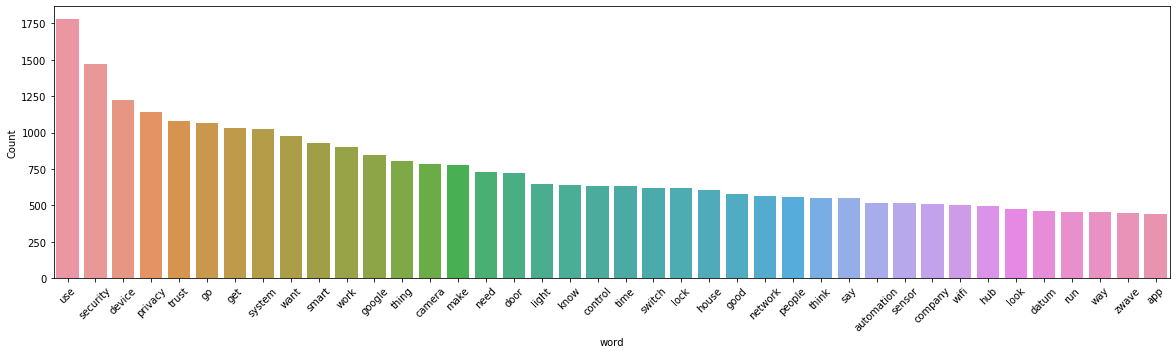

In [200]:
freq_words(df['clean_body'], False, 40)

In [194]:
def comment2token(comments):
    '''
    Return sequence (stream, generator) of sentences,
    with each sentence a list of tokens
    '''
    return [comment.split() for comment in comments]

comment_token_list = comment2token(df['clean_body'])

# Train Bigram and Trigram Models
# higher threshold fewer phrases.
bigram = gensim.models.Phrases(comment_token_list, min_count=20, threshold=300)

# Frequency of n-gram words
dist = nltk.FreqDist(
    [word for comment in bigram[comment_token_list] for word in comment if '_' in word])

# Sort frequency
print('Sorted trigrams: \n')
print(sorted(dist.items(), key=lambda x: x[1], reverse=True))
print('-'*20)

Sorted trigrams: 

[('third_party', 42), ('raspberry_pi', 40), ('_', 40), ('blue_iris', 29), ('person_in_address_book', 1), ('info_we_collect', 1), ('tp_link', 1), ('domain_comvrsn', 1), ('amzn_ssid', 1), ('amzn_pw', 1), ('lemon_tea', 1), ('not_home', 1), ('eternal_peril', 1), ('automate_the_thing', 1), ('ok_hand', 1), ('t_d', 1)]
--------------------


In [198]:
# df[df["clean_body"].str.lower().str.contains("")]

In [199]:
# Create a new columns with tokens
df['token_text'] = [[word for word in comment.split()] for comment in df['clean_body']]

In [10]:
# Add Wikipedia corpus
#with open('train_wiki.json', 'r') as f:
#    train_wiki = json.load(f)

#link = []
#category = []
#body_par = []

#for item in train_wiki:
#    link.append(item['link'])
#    category.append(item['category'])
#    body_par.append(item['body_par'])

# wiki_text= []
# for elm in body_par:
#     wiki_text.append(' '.join(elm))

# wiki_text = pd.DataFrame({'wiki_text': wiki_text})

# # Apply function to clean the comment
# wiki_text['wiki_clean'] = wiki_text.wiki_text.apply(clean_comment, lemma=True)
# wiki_text['token_text'] = [[word for word in comment.split()] for comment in wiki_text['wiki_clean']]

In [201]:
comment = df['token_text']
# comment = pd.concat([wiki_text['token_text'], df['token_text']], ignore_index=True)

In [202]:
# Create Dictionary
dictionary = corpora.Dictionary(comment)

# Term Document Frequency >> (id, freq) for each page
corpus = [dictionary.doc2bow(text) for text in comment]

# print('\nPrint words and frequencies in the first comment:\n')
# print([[(dictionary[id], freq) for id, freq in page] for page in corpus[3:4]])
# print('-' * 20)

## TF-IDF

Small tfidf:

vacuums: 0.03328732097497261
landscaping: 0.03328732097497261
hourlong: 0.03328732097497261
cradle: 0.03328732097497261
mailman: 0.03328732097497261
ringer: 0.03328732097497261
preparation: 0.03328732097497261
offtime: 0.03328732097497261
awake: 0.03328732097497261
tracked: 0.03328732097497261

Large tfidf:

close: 1.0
security: 1.0
trust: 1.0
follow: 1.0
homekitprivacy: 1.0
upgrade: 1.0
hah: 0.9701651680907885
rating: 0.9609096452151494
film: 0.9609067018243865
weak: 0.9471942181208346


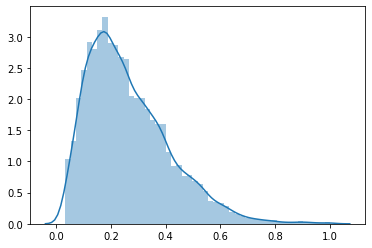

In [203]:
# TF-IDF model as pre-processing step
cv = CountVectorizer()
comment_token_vector = cv.fit_transform(df['clean_body'])
# comment_token_vector = cv.fit_transform(pd.concat([wiki_text['wiki_clean'],
#                                                    df['clean_body']], ignore_index=True))

# Compute the IDF values
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(comment_token_vector)

# Compute the TFIDF score (new unseen dataset)
count_vector = cv.transform(df['clean_body'])
tfidf_vector = tfidf_transformer.transform(count_vector)

# Check if it makes sense
feature_names = np.array(cv.get_feature_names())

# Remove the words that do not appear in the unseen dataset
zero_index = np.where(tfidf_vector.max(0).toarray()[0] == 0)[0]
feature_names = np.delete(feature_names, zero_index)
tfidf_vector = np.delete(tfidf_vector.max(0).toarray()[0], zero_index)

# max(0) equal max by columns
# argsort: return the indices that would sort an array
# sorted_tfidf_index = tfidf_vector.max(0).toarray()[0].argsort()
sorted_tfidf_index = tfidf_vector.argsort()

# Small: words commonly used across all documents and rarely used 
# in the particular document/low frequency term 
print('Small tfidf:\n')
for i in sorted_tfidf_index[:10]:
    print('{}: {}'.format(feature_names[i],
                                           tfidf_vector[i]))
# Large: Term that appears frequently in a particular document, but not often in the corpus.
print('\nLarge tfidf:\n')
for i in sorted_tfidf_index[:-11:-1]:
    print('{}: {}'.format(feature_names[i],
                                           tfidf_vector[i]))
    
sns.distplot(tfidf_vector)
# CONSIDER: find score threshold where words are deleted

In [204]:
# Find the optimal number of topics
def LdaMallet_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 3):
    '''
    Compute c_v coherence for various number of topics
    
    Parameters:
    ---------
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    texts: list of input texts
    limit: max num of topics
    
    Returns:
    ---------
    model_list: list of LDA topic models
    coherence_values: corresponding to the LDA model
    '''
    
    mallet_path = 'mallet-2.0.8/bin/mallet'
    
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        print('Running model with number of topics: ', num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = num_topics, id2word = dictionary)
        model_list.append(model)

        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

def LDA_coherence_values(dictionary, corpus, texts, limit, chunksize = 100, start=2, step=3):
    '''
    Compute c_v coherence for various number of topics

    Parameters:
    ---------
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    texts: list of input text 
    chunksize: number of documents to be used in each training chunk
    limit: max num of topics

    Returns:
    ---------
    model_list: list of LDA topic
    coherence_values: corresponding to the LDA model
    '''

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        print('Running model with number of topics: ', num_topics)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary,
                                                num_topics=num_topics, random_state=100, 
                                                update_every=1, chunksize=100, passes=10, 
                                                alpha='auto', per_word_topics=True)
        
        model_list.append(model)

        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [205]:
model_list, coherence_values = LDA_coherence_values(dictionary=dictionary, corpus=corpus, 
                                                          texts=comment, start=2, limit=10, step=1)

Running model with number of topics:  2
Running model with number of topics:  3
Running model with number of topics:  4
Running model with number of topics:  5
Running model with number of topics:  6
Running model with number of topics:  7
Running model with number of topics:  8
Running model with number of topics:  9


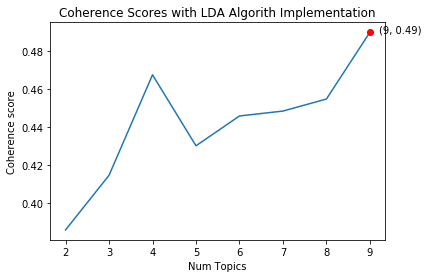

In [206]:
limit = 10
start=2
step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.plot(x[np.argmax(coherence_values)], max(coherence_values), 'or')
plt.text(x[np.argmax(coherence_values)]+0.2, max(coherence_values), 
         r'({}, {})'.format(x[np.argmax(coherence_values)], np.round(max(coherence_values), 2)))
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.title('Coherence Scores with LDA Algorith Implementation')
# plt.savefig('output/Topics_Coher_LDA_Model_page')
plt.show()

In [207]:
print('\nLDA model: \n')
for num, cv in zip(x, coherence_values):
    print('Nun Topics =', num, ' has Coherence Value of', round(cv, 4))
print('-'*20)


LDA model: 

Nun Topics = 2  has Coherence Value of 0.386
Nun Topics = 3  has Coherence Value of 0.4147
Nun Topics = 4  has Coherence Value of 0.4674
Nun Topics = 5  has Coherence Value of 0.4302
Nun Topics = 6  has Coherence Value of 0.4458
Nun Topics = 7  has Coherence Value of 0.4484
Nun Topics = 8  has Coherence Value of 0.4547
Nun Topics = 9  has Coherence Value of 0.4897
--------------------


In [208]:
# Extract the model base on the topic number
def model_extract(num_topics):
    '''
    Input: num_topics (int)
    '''
    # get number of topics
    num, _ = zip(*list(zip(x,coherence_values)))
    model = model_list[[i for i in range(len(num)) if num[i] == num_topics][0]]
    
    return model

model = model_extract(4)

In [209]:
# save model to disk
temp_file = datapath("query_comm")
model.save(temp_file)
# Load a potentially pretrained model from disk.
# lda = LdaModel.load(temp_file)

In [210]:
model_topics = model.show_topics(num_topics=4, num_words=10,formatted = False)

In [211]:
print('\n LDA topics: \n')
for topic, keyword in model.print_topics(num_words=20):
    print('Topic: ', topic)
    print('Keywords: ', keyword)
print('-'*20)


 LDA topics: 

Topic:  0
Keywords:  0.039*"device" + 0.032*"network" + 0.020*"access" + 0.017*"internet" + 0.015*"datum" + 0.013*"security" + 0.012*"secure" + 0.011*"wifi" + 0.009*"router" + 0.009*"identical" + 0.008*"cloud" + 0.008*"server" + 0.008*"firmware" + 0.008*"local" + 0.007*"hack" + 0.006*"iot" + 0.006*"vlan" + 0.005*"connect" + 0.004*"run" + 0.004*"ip"
Topic:  1
Keywords:  0.012*"burn" + 0.009*"mode" + 0.007*"phyn" + 0.007*"com" + 0.006*"contact" + 0.006*"click" + 0.005*"plate" + 0.004*"sd" + 0.004*"pressure" + 0.004*"card" + 0.004*"copper" + 0.004*"would" + 0.004*"plumber" + 0.003*"ac" + 0.003*"credit" + 0.003*"welcome" + 0.003*"knock" + 0.003*"reply" + 0.003*"member" + 0.003*"ramp"
Topic:  2
Keywords:  0.021*"system" + 0.017*"use" + 0.017*"switch" + 0.016*"smart" + 0.012*"lock" + 0.012*"door" + 0.010*"automation" + 0.010*"house" + 0.010*"get" + 0.010*"light" + 0.009*"zwave" + 0.009*"wire" + 0.009*"control" + 0.009*"want" + 0.009*"homeseer" + 0.008*"bulb" + 0.008*"work" + 

In [212]:
# Visualize the topics
# Takes a lot of time to run
# mds='TSNE'
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.212599 -0.184448       1        1  44.378593
2      0.173658  0.208937       2        1  40.960373
0     -0.208733  0.045418       3        1  12.420948
1     -0.177524 -0.069907       4        1   2.240084, topic_info=     Category         Freq         Term        Total  loglift  logprob
151   Default  2659.000000        trust  2659.000000  30.0000  30.0000
67    Default  1030.000000       device  1030.000000  29.0000  29.0000
367   Default   508.000000      network   508.000000  28.0000  28.0000
81    Default  1148.000000       system  1148.000000  27.0000  27.0000
200   Default   913.000000       switch   913.000000  26.0000  26.0000
...       ...          ...          ...          ...      ...      ...
4371   Topic4     6.720372  description     7.854901   3.6427  -6.0685
101    Topic4    18.929871          com    30.806854   3.3117  -5.0329
173    Topic4    18.307211      contact    55.554970   2.6886  -5.0663
438    Topic4    11.798254         card    46.765114   2.4215  -5.5057
1703   Topic4     7.165879      message    59.631363   1.6798  -6.0043

[214 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2144      4  0.921293          ac
3936      4  0.865304  acceptable
291       2  0.119890      access
291       3  0.879192      access
2002      3  0.976535  accessible
...     ...       ...         ...
153       1  0.419711        work
153       2  0.580534        work
1609      4  0.924284       would
501       2  0.995152      zigbee
241       2  0.998098       zwave

[242 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

In [213]:
# Extract the topic with highest security, trust and privacy

def relevent_topic(num_topics, query):
    '''
    Input:
        > num_topics: integer
        > query: term string
    '''
    print('{} topics:\n'.format(query.upper()))
    relevant = [(num, dist) for num, dist in model.show_topics(num_words=20, num_topics = num_topics) if len(re.findall(query, dist)) != 0]
    
    for i in relevant:
        print('Topic: {}'.format(i[0]))
        print('Distribution: {}\n'.format(i[1]))


In [214]:
relevent_topic(4, 'security')
relevent_topic(4, 'privacy')
relevent_topic(4, 'trust')

SECURITY topics:

Topic: 0
Distribution: 0.039*"device" + 0.032*"network" + 0.020*"access" + 0.017*"internet" + 0.015*"datum" + 0.013*"security" + 0.012*"secure" + 0.011*"wifi" + 0.009*"router" + 0.009*"identical" + 0.008*"cloud" + 0.008*"server" + 0.008*"firmware" + 0.008*"local" + 0.007*"hack" + 0.006*"iot" + 0.006*"vlan" + 0.005*"connect" + 0.004*"run" + 0.004*"ip"

PRIVACY topics:

TRUST topics:

Topic: 3
Distribution: 0.046*"trust" + 0.014*"company" + 0.014*"get" + 0.012*"go" + 0.012*"use" + 0.011*"product" + 0.011*"say" + 0.011*"know" + 0.010*"think" + 0.009*"make" + 0.009*"people" + 0.008*"google" + 0.008*"thing" + 0.008*"camera" + 0.007*"support" + 0.007*"try" + 0.006*"time" + 0.006*"money" + 0.006*"pay" + 0.006*"customer"



In [215]:
# Find the dominant topic in each sentence
# Find the topic number with the highest percentage contribution in that document

def dominant_topic(ldamodel, corpus, texts):
    # init dataframe
    topics_df = pd.DataFrame()

    # GET MAIN TOPIC IN EACH WEBPAGE
    # Get throught the pages
    for num, page in enumerate(ldamodel[corpus]):
        # Count number of list into a list
        if sum(isinstance(i, list) for i in page)>0:
            page = page[0]

        page = sorted(page, key= lambda x: (x[1]), reverse=True)
    
        for j, (topic_num, prop_topic) in enumerate(page):
            if j == 0: # => dominant topic
                # Get list prob. * keywords from the topic
                pk = ldamodel.show_topic(topic_num)
                topic_keywords = ', '.join([word for word, prop in pk])
                # Add topic number, probability, keywords and original text to the dataframe
                topics_df = topics_df.append(pd.Series([int(topic_num), np.round(prop_topic, 4),
                                                    topic_keywords, texts[num]]),
                                                    ignore_index=True)
            else:
                break
                
    # Add columns name
    topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']

    return topics_df


In [216]:
target_corpus = [dictionary.doc2bow(text) for text in df['token_text']]

In [217]:
dominant_df = dominant_topic(model, target_corpus, df['body'])
dominant_df

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,3.0,0.4702,"trust, company, get, go, use, product, say, kn...","Not sure if you're going for humor, or just be..."
1,3.0,0.5215,"trust, company, get, go, use, product, say, kn...",Are you commenting from your smart phone? Beca...
2,3.0,0.4772,"trust, company, get, go, use, product, say, kn...",People will eventually start talking about EM ...
3,3.0,0.4603,"trust, company, get, go, use, product, say, kn...",My suggestion is just don’t use voice assistan...
4,3.0,0.4935,"trust, company, get, go, use, product, say, kn...","There's an open source version, if you're a te..."
...,...,...,...,...
2899,2.0,0.7348,"system, use, switch, smart, lock, door, automa...",If you want the best combination of reliabilit...
2900,2.0,0.5835,"system, use, switch, smart, lock, door, automa...",Agreed. Personally I find the prices on some o...
2901,3.0,0.7325,"trust, company, get, go, use, product, say, kn...",What I trust is their ethos. Maybe I'm delusio...
2902,3.0,0.8051,"trust, company, get, go, use, product, say, kn...",&gt; It's not a bug in the switches. If it wer...


In [220]:
df[:1]

,author,body,created_utc,id,link_id,parent_id,permalink,score,subreddit,URL,clean_body,token_text
0,othergallow,"Not sure if you're going for humor, or just be...",1574910012,f8x71w0,t3_e2q4mj,t1_f8x6fog,/r/homeautomation/comments/e2q4mj/is_there_a_p...,1,homeautomation,[],sure go humor snarky funny talk way give priva...,"[sure, go, humor, snarky, funny, talk, way, gi..."


In [221]:
# Find the most representative document for each topic in order to infer the topic
ref_document = pd.DataFrame()
df_topic_grouped = dominant_df.groupby('Dominant_Topic')

for i, grp in df_topic_grouped:
    # populate the sorted dataframe with the page that contributed the most to the topic
    ref_document = pd.concat([ref_document, grp.sort_values(['Perc_Contribution'], ascending = [0]).head(1)], axis = 0)
    
# Reset Index and change columns name
ref_document.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

ref_document.head(20)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
1288,0.0,0.7486,"device, network, access, internet, datum, secu...",That works great for ethernet but a malicious ...
776,1.0,0.6535,"burn, mode, phyn, com, contact, click, plate, ...",Did a WHOIS lookup and it didn't really reveal...
1744,2.0,0.9538,"system, use, switch, smart, lock, door, automa...",Go with Philips Hue gateway and buy Gledopto l...
568,3.0,0.9240,"trust, company, get, go, use, product, say, kn...",Thanks for the respect but downvotes really do...


In [229]:
print(df['body'][568])


Thanks for the respect but downvotes really don't matter to me. That would be to imply the opinion of redditors is valuable and I've never been convinced that's even remotely true.


Your opinion stands in stark contrast to that - you make good points about the assumption of privacy.  These are things that should be thoroughly discussed and disclosed.

As to the credibility of that site, I have done a fair bit of research on them and I'm prepared to agree that they are an actual news site.  


In [233]:
# Calculate Jensen-Shannon distance between two probability distributions using scipy.stats.entropy.
# Create Document - Topic Matrix

# column names
topicnames = ["Topic" + str(i) for i in range(len(model.print_topics()))]

# index names
docnames = ["Doc" + str(i) for i in range(df.shape[0])]

# Make the pandas dataframe
doc_topic = pd.DataFrame(columns=topicnames, index=docnames)

# Populate the matrix with topic probability distribution for a document
for doc_num, dist in enumerate(model[target_corpus]):
    for i in dist[0]:
        doc_topic.iloc[doc_num,i[0]] = i[1]

doc_topic = doc_topic.fillna(0)

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
doc_topic_vis = doc_topic.style.applymap(color_green).applymap(make_bold)




In [ ]:
doc_topic_vis.head(10)

In [32]:
def jensen_shannon_distance(p, q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions
    """

    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2

    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)

    return distance

In [33]:
# Make the pandas dataframe
js_matrix = pd.DataFrame(columns=np.array(range(df.shape[0])), index=np.array(range(df.shape[0])))

for i in range(js_matrix.shape[0]):
    for j in range(js_matrix.shape[0]):
        js_matrix.iloc[i,j] = jensen_shannon_distance(doc_topic.iloc[i,:], doc_topic.iloc[j,:])

In [34]:
# TODO
# Get reference document by topic and the related ones top 3 for topics of interest
for i in range(len(model.show_topics())):
    print('\nTopic', int(ref_document.iloc[i,0]))
    print('Keywords:', ref_document.iloc[i,2])
    print('Reference comment:', ref_document.index[i])
    print('Link: https:www.reddit.com{}'.format(df['permalink'][ref_document.index[i]]))
    related_comments = np.where((js_matrix.iloc[ref_document.index[i]] < 0.5) &
                                (js_matrix.index != ref_document.index[i]))[0]
    print('Related comments: ')
    for j in related_comments:
        print('https:www.reddit.com{}'.format(df['permalink'][j]))
        



Topic 0
Keywords: display, camera, cheap, home, use, security, think, go, alert, get
Reference comment: 17
Link: https:www.reddit.com/r/homeautomation/comments/dz2lx4/tablet_survey_results/f84wsnl/
Related comments: 
https:www.reddit.com/r/smarthome/comments/dz3d1m/amazon_confirms_police_can_keep_ring_doorbell/f85otox/
https:www.reddit.com/r/homeautomation/comments/dzgieb/what_is_the_correct_way_to_wire_a_house_for_home/f887mg7/
https:www.reddit.com/r/homeautomation/comments/dzgieb/what_is_the_correct_way_to_wire_a_house_for_home/f87h5xv/
https:www.reddit.com/r/homeautomation/comments/dz2lx4/tablet_survey_results/f850xaf/
https:www.reddit.com/r/homeautomation/comments/dy6w8l/best_video_phone/f7z2dgn/
https:www.reddit.com/r/smarthome/comments/dvfb7d/what_is_the_difference_between_smart_bulbs_like/f7xr5tu/
https:www.reddit.com/r/homeautomation/comments/dy058y/somfy_blinds_first_home_automation_project/f7xqaii/
https:www.reddit.com/r/homeautomation/comments/dxuk5q/light_controller_withou

In [231]:
# How much are topics related to each other?

# Make the pandas dataframe
topics_dictionary = pd.DataFrame(columns=np.array(range(len(dictionary))), index=np.array(range(len(model.get_topics()))))

# Populate the matrix with word probability distribution for a topic
for i in range(len(model.get_topics())):
    word_prob = model.get_topic_terms(i, topn=len(dictionary))
    for j in word_prob:
        topics_dictionary.iloc[i, j[0]] = j[1]

topics_dictionary = topics_dictionary.fillna(0)
    
# Make the pandas dataframe
js_topics = pd.DataFrame(columns=np.array(range(len(model.get_topics()))), index=np.array(range(len(model.get_topics()))))

for i in range(js_topics.shape[0]):
    for j in range(js_topics.shape[0]):
        js_topics.iloc[i,j] = jensen_shannon_distance(topics_dictionary.iloc[i,:], topics_dictionary.iloc[j,:])

In [232]:
js_topics

,0,1,2,3
0,0,0.607595,0.685079,0.702361
1,0.607595,0,0.683657,0.685396
2,0.685079,0.683657,0,0.639245
3,0.702361,0.685396,0.639245,0


In [36]:
# Check most relevant topic to the given word
# dictionary.token2id['privacy']
# model.get_term_topics(618)